### Imports

In [1]:
import matplotlib as mpl
import os.path as path

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tools.tools import set_size, save_fig, evaluate_drl_policy, evaluate_bs_policy, evaluate_strm_policy, extract_info_dict, extract_disruption_duration, extract_info_list, double_row_plot, extract_resilience_data, create_resilience_table, create_resilience_plot_complete, create_distribution_boxplots

import pandas as pd
from collections import defaultdict
import matplotlib.patches as mpatches

from supply_chain_env import SupplyChainEnv
from config import Config

from stable_baselines3 import PPO

print("Your style sheets are located at: {}".format(path.join(mpl.__path__[0], 'mpl-data', 'stylelib')))

Duplicate key in file PosixPath('/Users/jakoblimmer/opt/anaconda3/envs/sc_disruptions/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/science.mplstyle'), line 52 ('legend.frameon : True')


Your style sheets are located at: /Users/jakoblimmer/opt/anaconda3/envs/sc_disruptions/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib


### Plot Style

In [2]:
# Using seaborn's style
plt.style.use('science')
plt.style.use('grid')
# With LaTex fonts
plt.style.use('thesis')
# Width of Thesis
width = 'thesis'

### Collect Evaluation Run

In [3]:
num_episodes = 100
seed = 0

conf = Config()
conf.MAX_STEPS = 200
conf.DISRUPTION_PROBABILITY_TOTAL = 1

env = SupplyChainEnv(conf, seed=conf.EVALUATION_SEED, deterministic_reset=True)
model = PPO.load(path.join("runtime", conf.EVALUATION_MODEL), env=env) 

base_stock_info = evaluate_bs_policy(env)
sterman_info = evaluate_strm_policy(env)
rsppo_info = evaluate_drl_policy(model, env)

disruptions = extract_disruption_duration(rsppo_info)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# 4.2 Basic Evaluation
## 4.2.1 Demand 

In [4]:
# demand = defaultdict(int)
# env_agg = SupplyChainEnv(conf)
# model = PPO.load(path.join("runtime", conf.EVALUATION_MODEL), env=env_agg) 
    
# for episode in range(10000):
#     obs, _ = env_agg.reset()
#     done = False

#     while not done:
#         action, _ = model.predict(obs, deterministic=False)
#         obs, reward, done, truncated, info = env_agg.step(action)
#         demand[info['step']] = demand[info['step']] + info['demand']

# for i in demand.keys(): 
#     demand[i] /= 10000
    
# pd.DataFrame({'step': demand.keys(), 'values': demand.values()}).to_csv(path.join('data', 'aggregated_demand.csv'), index = False)

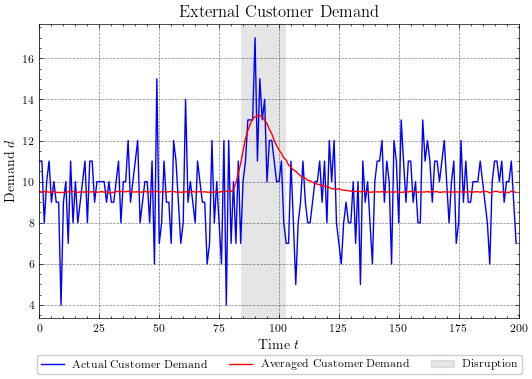

In [5]:
df = pd.read_csv(path.join('data', 'aggregated_demand.csv'))
demand = df.set_index('step')['values'].to_dict()

fig, ax = plt.subplots(1, 1, figsize=set_size(width))

ax.plot(extract_info_dict(rsppo_info, 'step'), extract_info_dict(rsppo_info, 'demand'))
ax.plot(demand.keys(), demand.values())
ax.axvspan(disruptions[0][0], disruptions[0][1], facecolor='k', alpha=0.1)
ax.set_xlim(left = 0, right = 200)
ax.set_ylabel(r'Demand $d$')
ax.set_xlabel(r'Time $t$')
ax.title.set_text(r'External Customer Demand')

demand_actual = Line2D([0], [0], label='Actual Customer Demand', color='blue')
demand_agg = Line2D([0], [0], label='Averaged Customer Demand', color='red')
disruption = mpatches.Patch(color='k', alpha= 0.1, label='Disruption')


handles = [demand_actual, demand_agg, disruption]

fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.513,-0.05), ncol=3)

save_fig(fig, 'customer_demand')

## 4.2.2 Inventory Leves & Actions

3


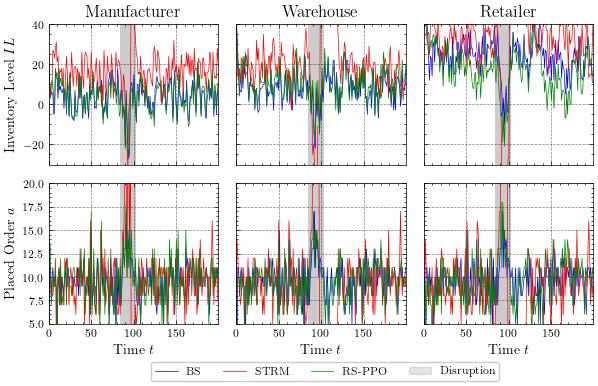

In [6]:
info_list = []
info_list.append(extract_info_list(base_stock_info, sterman_info, rsppo_info, 'inventory_levels'))
info_list.append(extract_info_list(base_stock_info, sterman_info, rsppo_info, 'orders_placed'))

double_row_plot_data = {'y_labels': [r'Inventory Level $IL$', r'Placed Order $a$'], 
                        'y_min_0': -30, 
                        'y_max_0': 40, 
                        'y_min_1': 5,
                        'y_max_1': 20 
                        }

double_row_plot(info_list, disruptions, double_row_plot_data, 'complete_evaluation_il_a')

## 4.2.3 Cost & Reward

3


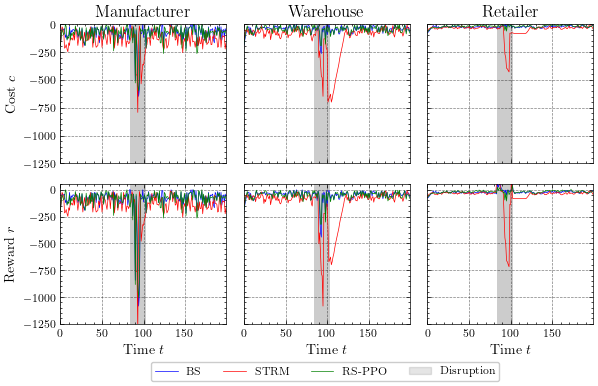

In [7]:
info_list = []
info_list.append(extract_info_list(base_stock_info, sterman_info, rsppo_info, 'cost'))
info_list.append(extract_info_list(base_stock_info, sterman_info, rsppo_info, 'reward'))

double_row_plot_data = {'y_labels': [r'Cost $c$', r'Reward $r$'], 
                        'y_min_0': -1250, 
                        'y_max_0': 0, 
                        'y_min_1': -1250,
                        'y_max_1': 50 
                        }

double_row_plot(info_list, disruptions, double_row_plot_data, 'complete_evaluation_c_r')

## 4.2.4 Overstock & Shortage

3


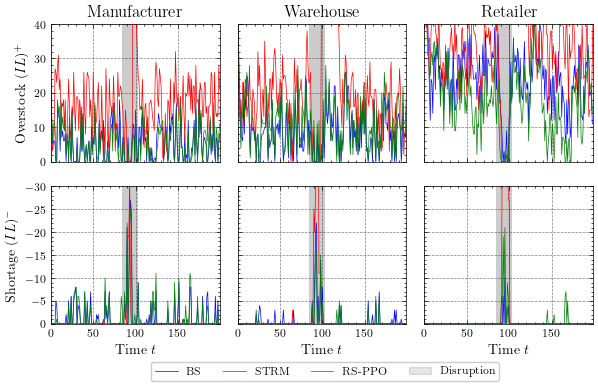

In [8]:
info_list = []
info_list.append(extract_info_list(base_stock_info, sterman_info, rsppo_info, 'overstock'))
info_list.append(extract_info_list(base_stock_info, sterman_info, rsppo_info, 'shortages'))

double_row_plot_data = {'y_labels': [r'Overstock $(IL)^{+}$', r'Shortage $(IL)^{-}$'], 
                        'y_min_0': 0, 
                        'y_max_0': 40, 
                        'y_min_1': 0,
                        'y_max_1': -30 
                        }

double_row_plot(info_list, disruptions, double_row_plot_data, 'complete_evaluation_overstock_shortage')

# 4.3 Resilience Analysis

## 4.3.1 Extract Resilience Data

In [9]:
res_info_1, res_df_1 = extract_resilience_data(rsppo_info)
res_info_2, res_df_2 = extract_resilience_data(base_stock_info)
res_info_3, res_df_3 = extract_resilience_data(sterman_info)


## 4.3.2 Create Resilience Tables

In [10]:
create_resilience_table(res_info_2, res_df_2, res_info_1, res_df_1, 'bs')
create_resilience_table(res_info_3, res_df_3, res_info_1, res_df_1, 'strm')

## 4.3.3 RS-PPO Resilience Plot

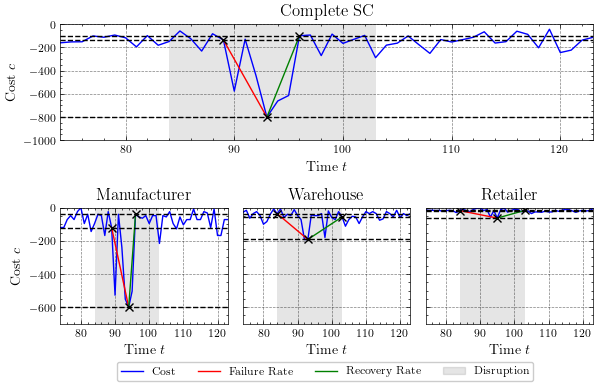

In [11]:
plot_data = {'y_min': -1000, 'y_max': 0, 'y_min_1': -700, 'y_max_1': 0}
create_resilience_plot_complete(rsppo_info, disruptions, plot_data, 'RSPPO')

## 4.3.4 BS Resilience Plot

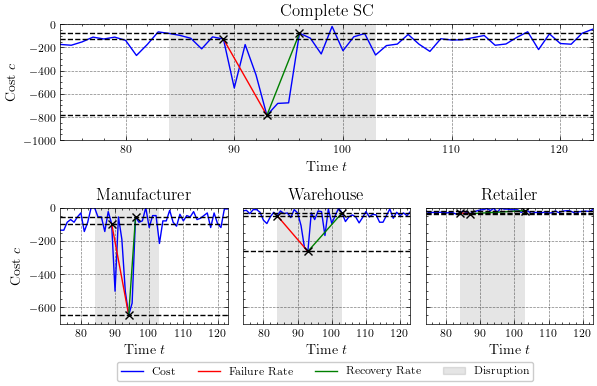

In [12]:
plot_data = {'y_min': -1000, 'y_max': 0, 'y_min_1': -700, 'y_max_1': 0}
create_resilience_plot_complete(base_stock_info, disruptions, plot_data, 'BS')

## 4.3.5 STRM Resilience Plot

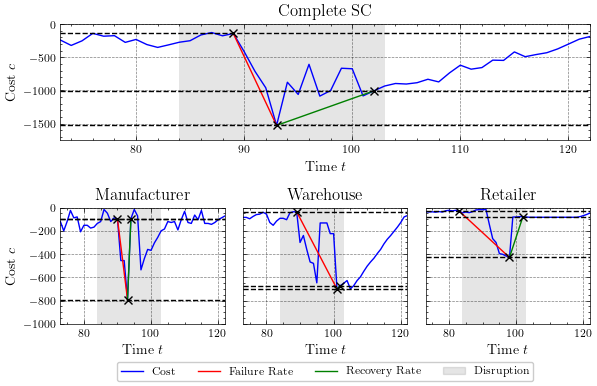

In [13]:
plot_data = {'y_min': -1750, 'y_max': 0, 'y_min_1': -1000, 'y_max_1': 0}
create_resilience_plot_complete(sterman_info, disruptions, plot_data, 'STRM')

# 4.4 Sensitivity Analysis
## 4.4.1  Demand distribution

In [14]:

from calculation import calculate_distribution_sensitivity

num_episodes = 100 

demand_distributions = {
    'normal': {
        'distribution': [(10, 2), (20, 2), (20, 4)], 
        'bs_levels': [[34, 49, 71], [73, 97, 95], [73, 97, 95]]
    },
    'uniform': {
        'distribution': [(0, 2), (0, 8), (10, 20)], 
        'bs_levels': [[6, 13, 31], [19, 22, 50], [56, 90, 96]]
    },
}

calculate_distribution_sensitivity(demand_distributions)   
            

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jakoblimmer/opt/anaconda3/envs/sc_disruptions/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


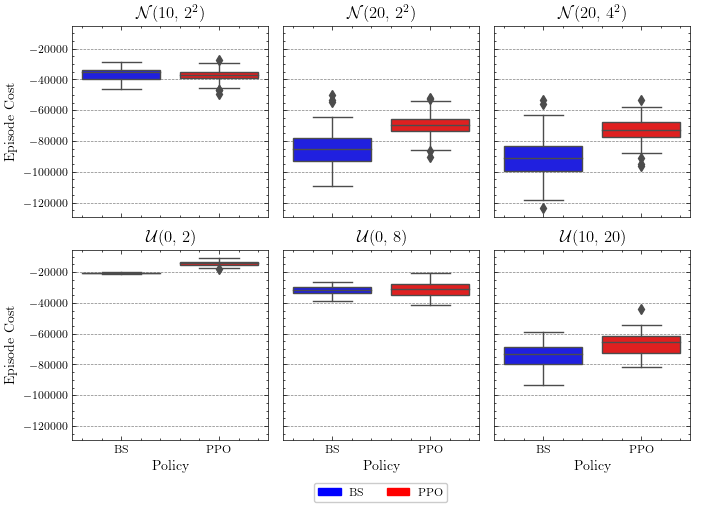

In [15]:
create_distribution_boxplots(demand_distributions, width)

## 4.4.2 Episode Length

In [13]:
from calculation import calculate_sensitivity
    
calculate_sensitivity(50, 350, 'MAX_STEPS')

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

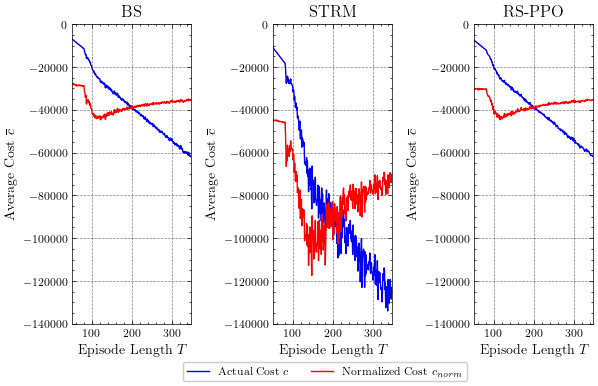

In [13]:

length = pd.read_csv(path.join('data', 'MAX_STEPS.csv'))

df = length

x_labels = [r'Episode Length $T$']
handles = []
cols = ['BS', 'STRM', 'PPO']
titles = ['BS', 'STRM', 'RS-PPO']
info_labels = [r'Actual Cost $c$', 'Normalized Cost $c_{norm}$']


fig, ax = plt.subplots(1, 3, figsize=set_size(width))

for i, col in enumerate(cols): 
    df[f'{col}_norm'] = (200 / df['x']) * df[f'{col}']
    # for col in ['BS', 'STRM', 'PPO']:
    handle, = ax[i].plot(df.x, df.loc[:, cols[i]], label = info_labels[0]) 
    handle_norm, = ax[i].plot(df.x, df.loc[:, f'{col}_norm'], label = info_labels[1]) 
    
    
    ax[i].set_xlim(left = df.x.min(), right = df.x.max())
    
    ax[i].set_ylim(-140000, 0)
    
    ax[i].set_xlabel(x_labels[0])
    ax[i].set_ylabel(r'Average Cost $\overline{c}$')
    ax[i].title.set_text(titles[i])

handles.append(handle)
handles.append(handle_norm)

fig.legend(handles=handles, labels=info_labels, 
            loc='lower center', bbox_to_anchor=(0.542,-0.04), ncol=3)

fig.tight_layout()

save_fig(fig, 'episode_length')
